## A simple demostration of how to run

In [ ]:
#https://github.com/cleardusk/3DDFA_V2/blob/master/demo.py

In [1]:
!git clone https://github.com/moonryul/3DDFA_V2.git

Cloning into '3DDFA_V2'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 669 (delta 4), reused 10 (delta 2), pack-reused 652
Receiving objects: 100% (669/669), 74.77 MiB | 36.90 MiB/s, done.
Resolving deltas: 100% (345/345), done.


In [2]:
!pwd


/content


In [4]:
%cd 3DDFA_V2

/content/3DDFA_V2


In [5]:
!sh build.sh


running build_ext
cythoning nms/cpu_nms.pyx to nms/cpu_nms.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/3DDFA_V2/FaceBoxes/utils/nms/cpu_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'nms.cpu_nms' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/nms
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I/usr/include/python3.7m -c nms/cpu_nms.c -o build/temp.linux-x86_64-3.7/nms/cpu

In [6]:
# before import, make sure FaceBoxes and Sim3DR are built successfully, e.g.,
# sh build.sh

import cv2
import yaml

from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
from utils.functions import draw_landmarks
from utils.render import render
from utils.depth import depth

import matplotlib.pyplot as plt

### Load configs

In [8]:
!pip install onnxruntime


     |████████████████████████████████| 4.1MB 5.7MB/s 


In [10]:
# load config
cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# """TDDFA: named Three-D Dense Face Alignment (TDDFA)"""
# 
#3D Dense Face Alignment/Reconstruction w. 3DDFA_V2: https://www.kaggle.com/balraj98/3d-dense-face-alignment-reconstruction-w-3ddfa-v2
#  Besides, 3DDFA_V2 incorporates the fast face detector FaceBoxes instead of Dlib. 
# Init FaceBoxes and TDDFA, recommend using onnx flag
#  ONNX provides an open source format for AI models, both deep learning and traditional ML. 
#It defines an extensible computation graph model, 
#as well as definitions of built-in operators and standard data types. 
#Currently we focus on the capabilities needed for inferencing (scoring).##
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    
    from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
    from TDDFA_ONNX import TDDFA_ONNX
    
    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    tddfa = TDDFA(gpu_mode=False, **cfg)
    face_boxes = FaceBoxes()

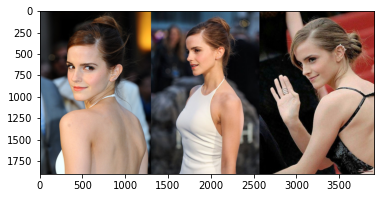

In [11]:
# given an image path
img_fp = 'examples/inputs/emma.jpg'
img = cv2.imread(img_fp)
plt.imshow(img[..., ::-1])

### Detect faces using FaceBoxes

In [12]:
# face detection
boxes = face_boxes(img)
print(f'Detect {len(boxes)} faces')
print(boxes)

Detect 3 faces
[[1699.8129, 278.4989, 2057.769, 762.43463, 0.9999492], [2999.3958, 304.8674, 3428.6719, 900.9678, 0.999895], [317.27075, 399.83636, 792.7346, 1048.3191, 0.99988747]]


### Regressing 3DMM parameters, reconstruction and visualization

In [13]:
# regress 3DMM params
param_lst, roi_box_lst = tddfa(img, boxes)

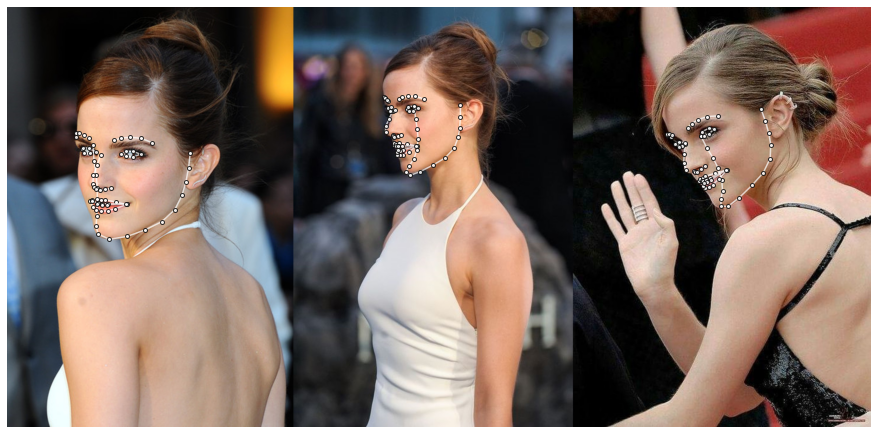

In [14]:
# reconstruct vertices and visualizing sparse landmarks
dense_flag = False
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

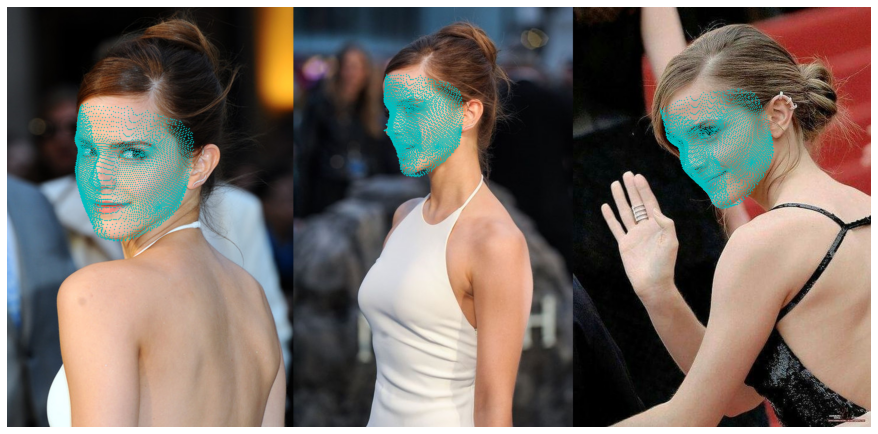

In [15]:
# reconstruct vertices and visualizing dense landmarks
dense_flag = True
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

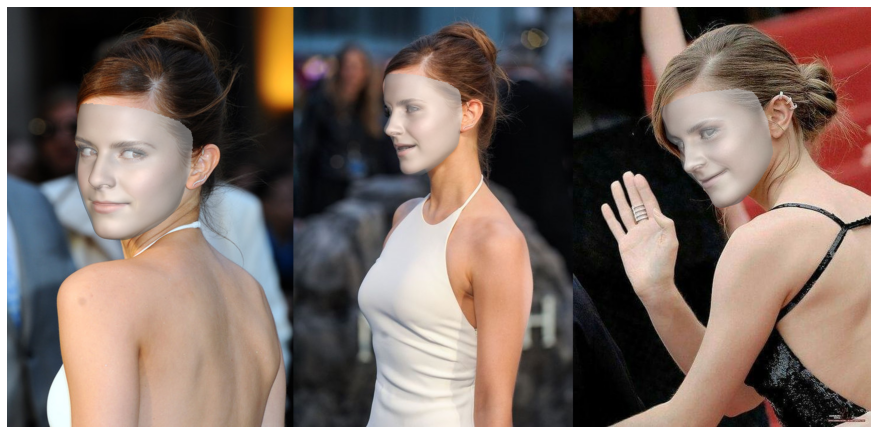

In [16]:
# reconstruct vertices and render
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
render(img, ver_lst, tddfa.tri, alpha=0.6, show_flag=True);

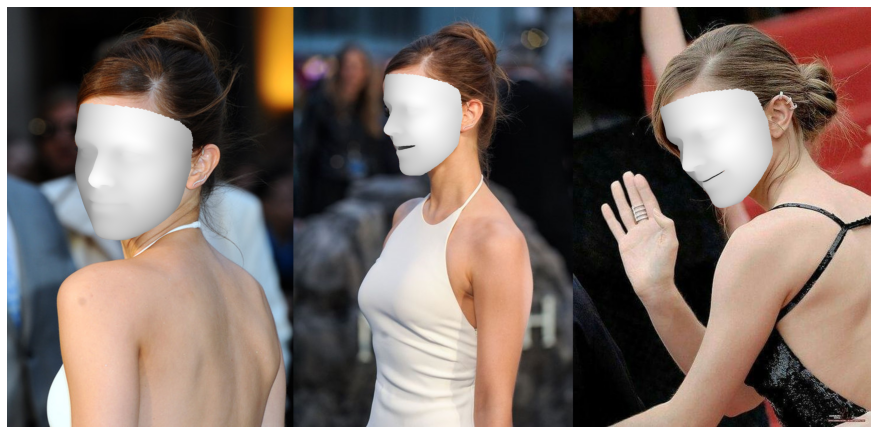

In [17]:
# reconstruct vertices and render depth
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
depth(img, ver_lst, tddfa.tri, show_flag=True);